<a href="https://colab.research.google.com/github/stefanocostantini/pytorch-book/blob/master/ch5_the_mechanics_of_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

## Regression problem

We have a thermometer which doesn't show the units, so we do measurements in both this instrument and celsius to have estimate a model that would allow us to determine the units of our 'unlabelled' thermometer

### Data

In [ ]:
# Measurement in celsius
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_c = torch.tensor(t_c) # convert to tensor

In [ ]:
# Measurement in unknown unit
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = torch.tensor(t_u) # convert to tensor

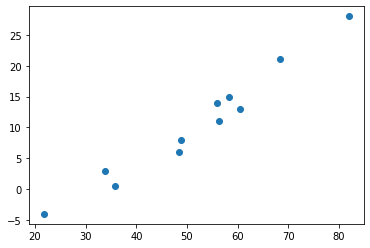

In [ ]:
# There appear to be a linear relationship between the two measures
plt.scatter(t_u, t_c)

### Model

It generally makes sense to start from the simplest model, a linear model (like linear regression): `t_c = w * t_u + b`

`w` and `b` are the `weight` and the `bias`, respectively. These are the parameters that we need to estimate.

We estimate them by finding the values of `w` and `b` that minimise the model's error. But to do that, we need to a measure of the error, i.e. we need a **loss function** of which we want to find the minimum.

This is the same as line fitting, but let's do it in pytorch. 

In [ ]:
# First we need to define the model
def model(t_u, w, b):
  return w * t_u + b

In [ ]:
# Then we define the loss function
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c) ** 2
  return squared_diffs.mean() 

In [ ]:
# Finally we can initialise the value of the scalars (zero dimension tensors),
# "run" the model and calculate the loss
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
print(t_p)

loss = loss_fn(t_p, t_c)
loss

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


tensor(1763.8846)

### Training

But how do we actually *estimate* `w` and `b` to make the loss as small as possible?

We'll optimise the loss function with respect to the parameters using the *gradient descent* algorithm.

In [ ]:
# We define functions that calculate the rate of change around a particular point
# for both w and b. These will tell us in which direction to change these parameters
# to change the loss.

# first define the increment around the point
delta = 0.1

# then the loss rate of change
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_u) - loss_fn(model(t_u, w - delta, b), t_u)) / 2.0 * delta
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_u) - loss_fn(model(t_u, w, b-delta), t_u)) / 2.0 * delta

# to avoid big jumps we scale down the rate of change by a learning rate
learning_rate = 1e-2

# so that the values of w and b are updated as follows
w = w - learning_rate * loss_rate_of_change_w
b = b - learning_rate * loss_rate_of_change_b

The above process is really not efficient and doesn't scale well. What we want instead is calculate the individual derivative of the loss function with respect to each parameter, and put them into a vector of derivatives, i.e. the *gradient*

In this case we have two parameters so our gradient will have 2 derivatives, i.e.

$$
 \nabla_{w,b}L = \left(\frac{\partial L}{\partial w}, \frac{\partial L}{\partial b}\right) = \left(\frac{\partial L}{\partial m} \frac{\partial m}{\partial w}, \frac{\partial L}{\partial m} \frac{\partial m}{\partial b}\right)
 $$

 using the chain rule. Specifically the first term is the derivative of the loss with respect to the output of the model (i.e. the prediction), while the second term is the derivative of the model with respect to one of its parameter.

In code we have the following: 

In [ ]:
# The partial derivative of the loss wrt the model output (t_p)
def dloss_fn(t_p, t_c):
  dsquared_diffs = 2 * (t_p - t_c) / t_p.size(0) # derivative of mean
  return dsquared_diffs

# The partial derivatives of the model wrt each of its parameters are:
def dmodel_dw(t_u, w, b):
  return t_u

def dmodel_db(t_u, w, b):
  return 1.0

In [ ]:
# Now we can define the gradience function
def grad_fn(t_u, t_c, t_p, w, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
  return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [ ]:
# Let's now set up the training loop, which will have a forward pass
# (calculation of prediction) and a backward pass (calculation of gradient). 
# The parameters will then be updated. This is repeated for as many epochs as
# selected
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_output = False):
  for epoch in range(1, n_epochs + 1):
    w, b = params
    # forward pass
    t_p = model(t_u, w, b)
    # backward pass
    loss = loss_fn(t_p, t_c) # we calculate this just to show it, it's already taken into account in gradient function
    grad = grad_fn(t_u, t_c, t_p, w, b)
    # update parameters
    params = params - learning_rate * grad
    if print_output:
      print(f'Epoch: {epoch}, Loss: {float(loss)}, Params: {params}, Grad: {grad}')
  return params  

In [ ]:
# And then we launch the training loop (100 epochs in this case)
training_loop(
    n_epochs = 15,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]), # random initialisation
    t_u = t_u,
    t_c = t_c,
    print_output=True
    )

Epoch: 1, Loss: 1763.8846435546875, Params: tensor([-44.1730,  -0.8260]), Grad: tensor([4517.2969,   82.6000])
Epoch: 2, Loss: 5802485.5, Params: tensor([2568.4014,   45.1637]), Grad: tensor([-261257.4219,   -4598.9712])
Epoch: 3, Loss: 19408035840.0, Params: tensor([-148527.7344,   -2616.3933]), Grad: tensor([15109614.0000,   266155.7188])
Epoch: 4, Loss: 64915909902336.0, Params: tensor([8589999.0000,  151310.8594]), Grad: tensor([-8.7385e+08, -1.5393e+07])
Epoch: 5, Loss: 2.171305598207918e+17, Params: tensor([-4.9680e+08, -8.7510e+06]), Grad: tensor([5.0539e+10, 8.9023e+08])
Epoch: 6, Loss: 7.262575831529281e+20, Params: tensor([2.8732e+10, 5.0610e+08]), Grad: tensor([-2.9229e+12, -5.1486e+10])
Epoch: 7, Loss: 2.429183992928415e+24, Params: tensor([-1.6617e+12, -2.9270e+10]), Grad: tensor([1.6904e+14, 2.9776e+12])
Epoch: 8, Loss: 8.125126681682404e+27, Params: tensor([9.6102e+13, 1.6928e+12]), Grad: tensor([-9.7764e+15, -1.7221e+14])
Epoch: 9, Loss: 2.7176891792249148e+31, Params: 

tensor([-2.0798e+26, -3.6636e+24])

The loss exploded, probably due to parameter updates that are are too large. Look how the value of the parameters oscillates more and more. It's a *diverging* optimisation process, exactly the opposite of what we want.

The first thing to try is to reduce the learning rate, we try `1e-4`

In [ ]:
training_loop(
    n_epochs = 15,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]), # random initialisation
    t_u = t_u,
    t_c = t_c,
    print_output = True
    )

Epoch: 1, Loss: 1763.8846435546875, Params: tensor([ 0.5483, -0.0083]), Grad: tensor([4517.2969,   82.6000])
Epoch: 2, Loss: 323.0905456542969, Params: tensor([ 0.3623, -0.0118]), Grad: tensor([1859.5493,   35.7843])
Epoch: 3, Loss: 78.92963409423828, Params: tensor([ 0.2858, -0.0135]), Grad: tensor([765.4667,  16.5122])
Epoch: 4, Loss: 37.5528450012207, Params: tensor([ 0.2543, -0.0143]), Grad: tensor([315.0790,   8.5787])
Epoch: 5, Loss: 30.540285110473633, Params: tensor([ 0.2413, -0.0149]), Grad: tensor([129.6733,   5.3127])
Epoch: 6, Loss: 29.351152420043945, Params: tensor([ 0.2360, -0.0153]), Grad: tensor([53.3495,  3.9682])
Epoch: 7, Loss: 29.148881912231445, Params: tensor([ 0.2338, -0.0156]), Grad: tensor([21.9303,  3.4148])
Epoch: 8, Loss: 29.113847732543945, Params: tensor([ 0.2329, -0.0159]), Grad: tensor([8.9964, 3.1869])
Epoch: 9, Loss: 29.107145309448242, Params: tensor([ 0.2325, -0.0162]), Grad: tensor([3.6721, 3.0930])
Epoch: 10, Loss: 29.105241775512695, Params: tens

tensor([ 0.2323, -0.0181])

This worked better, we can see that soon the value of the loss stabilises and the value of the parameters does not change that much. 

However, after a while the loss stabilises. There is a potential other problem here, the gradient. We see in Epoch 1 that the gradient for `w` is much bigger than the gradient for `b`. As the two parameters are in *differently scaled spaces*, it's unlikely that the learning rate will be optimal for both. So the solution is to scale the inputs. We can do this as follows:

In [ ]:
t_un = 0.1 * t_u

In [ ]:
# then we re-run the training loop
training_loop(
    n_epochs = 15,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]), # random initialisation
    t_u = t_un,
    t_c = t_c,
    print_output = True
    )

Epoch: 1, Loss: 80.36434173583984, Params: tensor([1.7761, 0.1064]), Grad: tensor([-77.6140, -10.6400])
Epoch: 2, Loss: 37.57491683959961, Params: tensor([2.0848, 0.1303]), Grad: tensor([-30.8623,  -2.3864])
Epoch: 3, Loss: 30.871076583862305, Params: tensor([2.2094, 0.1217]), Grad: tensor([-12.4631,   0.8587])
Epoch: 4, Loss: 29.756193161010742, Params: tensor([2.2616, 0.1004]), Grad: tensor([-5.2218,  2.1327])
Epoch: 5, Loss: 29.50714874267578, Params: tensor([2.2853, 0.0740]), Grad: tensor([-2.3715,  2.6310])
Epoch: 6, Loss: 29.392457962036133, Params: tensor([2.2978, 0.0458]), Grad: tensor([-1.2492,  2.8241])
Epoch: 7, Loss: 29.298828125, Params: tensor([2.3059, 0.0168]), Grad: tensor([-0.8071,  2.8970])
Epoch: 8, Loss: 29.208717346191406, Params: tensor([ 2.3122, -0.0124]), Grad: tensor([-0.6325,  2.9227])
Epoch: 9, Loss: 29.119417190551758, Params: tensor([ 2.3178, -0.0417]), Grad: tensor([-0.5633,  2.9298])
Epoch: 10, Loss: 29.030487060546875, Params: tensor([ 2.3232, -0.0710]),

tensor([ 2.3491, -0.2169])

We can see that even with a learning rate of `1e-2`, the optimisation no longer explodes. Finally, let's run the model for 5,000 epochs and see the value of the parameters.

In [ ]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]), # random initialisation
    t_u = t_un,
    t_c = t_c,
    print_output = False
    )

In [ ]:
params

tensor([  5.3671, -17.3012])

These values look familiar, as they are (very close to the value of) the parameters to go from Celsius to Fahrenheit degrees (the missing unit from the thermometers)

We can visualise that this is a good fit, as follows:

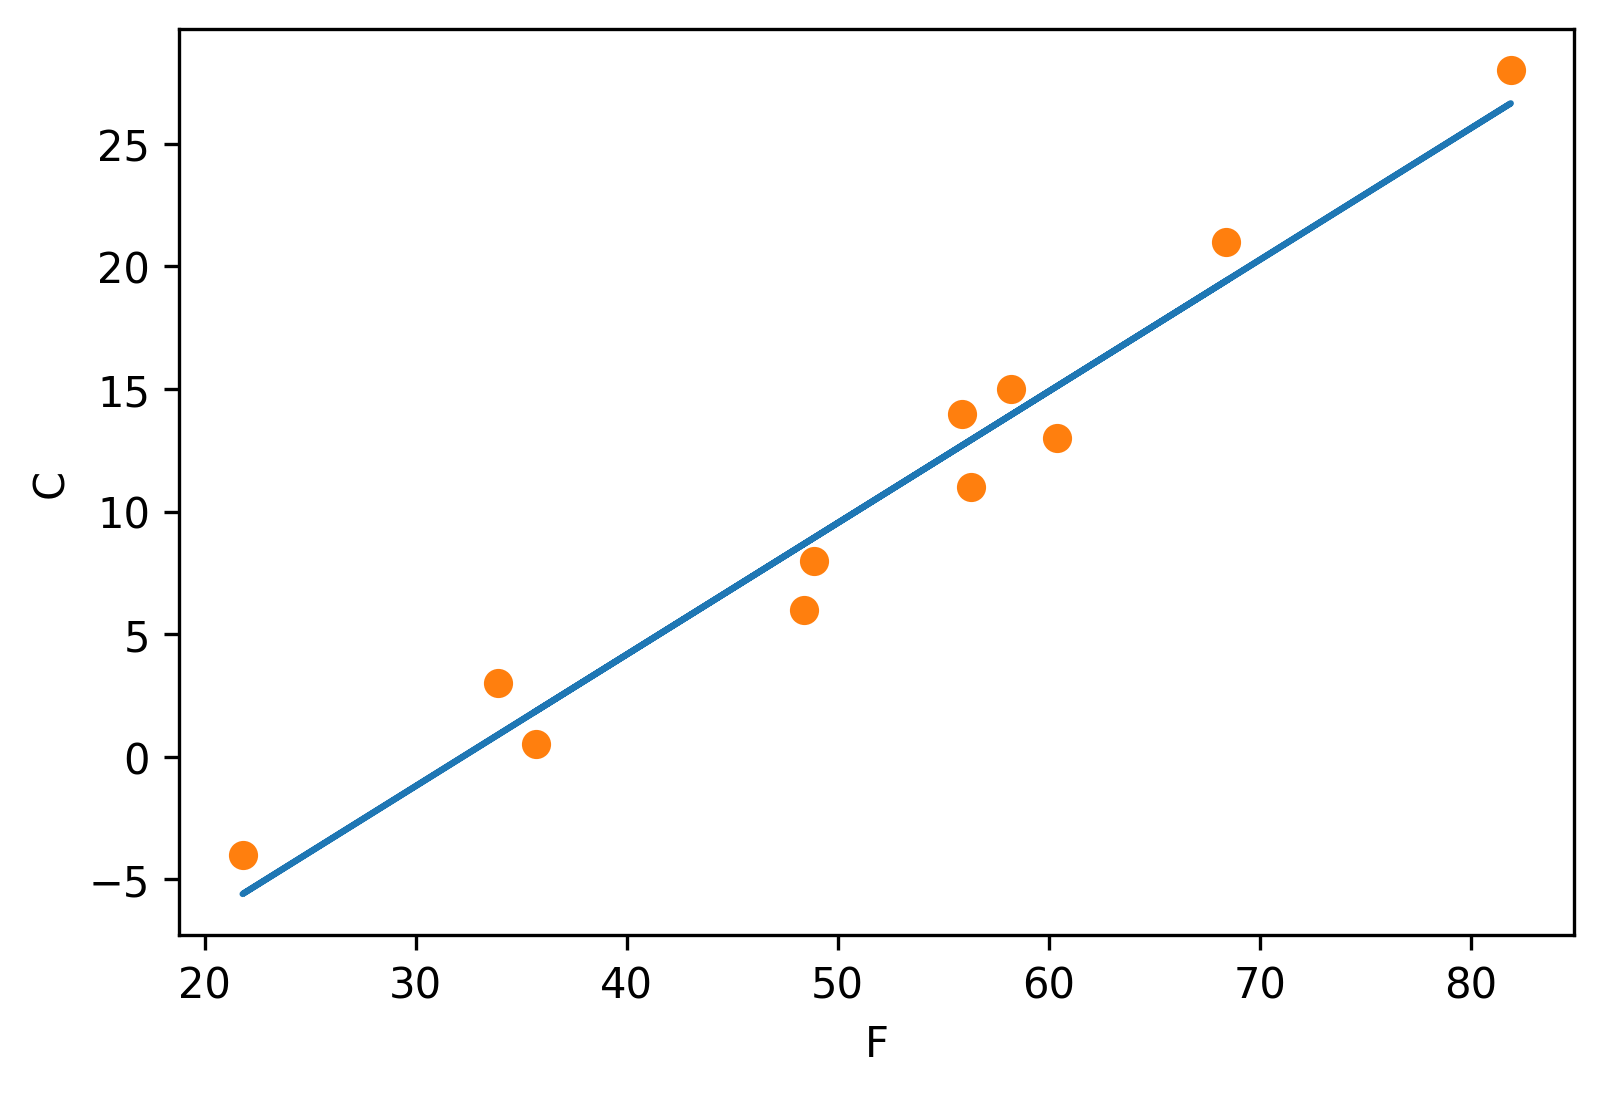

In [ ]:
t_p = model(t_un, *params) # argument unpacking

fig = plt.figure(dpi=300)
plt.xlabel("F")
plt.ylabel("C")
plt.plot(t_u, t_p)
plt.plot(t_u, t_c, 'o')

## Using PyTorch's autograd (automatic gradient calculation)

PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs. 

This means we won't need to derive our model by hand: given a forward expression, no matter how nested, PyTorch will automatically provide the gradient of that expression with respect to its input parameters.

In [ ]:
# We can use autograd by passing the 'requires_grad=True' parameter when we 
# initialise the parameters
params = torch.tensor([1.0, 0.0], requires_grad=True)

loss = loss_fn(model(t_u, *params), t_c)
loss.backward() # this triggers the calculation of the gradient

# and we can see the gradient here:
params.grad

tensor([4517.2969,   82.6000])

** NOTE: ** PyTorch accumulates the value of derivatives in the grad attributes. this could lead to an incorrect value of the gradient if `backward` was called earlier.  

At each iteration, We need to zero the gradient explicitly after using it for parameter updates, as follows:
```
if params.grad is not None:
  params.grad.zero_()
```

In [ ]:
# We can now re-define the training loop using autograd
def training_loop_auto(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None:
      params.grad.zero_()

    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    loss.backward() # this means that params.grad will now be calculated

    with torch.no_grad(): # to prevent Pytorch from adding edges to the forward graph
      params -= params.grad * learning_rate

    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, Loss: {loss}, Grad: {params.grad}, Params: {params}')
    
  return params

In [ ]:
# Let's now run the training again - we should be getting the same result as 
# above. 
params = training_loop_auto(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True), # requires_grad set to true!
    t_u = t_un,
    t_c = t_c
    )

params

Epoch: 500, Loss: 7.8601155281066895, Grad: tensor([-0.2252,  1.2748]), Params: tensor([ 4.0443, -9.8133], requires_grad=True)
Epoch: 1000, Loss: 3.828537940979004, Grad: tensor([-0.0962,  0.5448]), Params: tensor([  4.8021, -14.1031], requires_grad=True)
Epoch: 1500, Loss: 3.092191219329834, Grad: tensor([-0.0411,  0.2328]), Params: tensor([  5.1260, -15.9365], requires_grad=True)
Epoch: 2000, Loss: 2.9576973915100098, Grad: tensor([-0.0176,  0.0995]), Params: tensor([  5.2644, -16.7200], requires_grad=True)
Epoch: 2500, Loss: 2.933133840560913, Grad: tensor([-0.0075,  0.0425]), Params: tensor([  5.3236, -17.0549], requires_grad=True)
Epoch: 3000, Loss: 2.9286482334136963, Grad: tensor([-0.0032,  0.0182]), Params: tensor([  5.3489, -17.1980], requires_grad=True)
Epoch: 3500, Loss: 2.9278297424316406, Grad: tensor([-0.0014,  0.0078]), Params: tensor([  5.3597, -17.2591], requires_grad=True)
Epoch: 4000, Loss: 2.9276793003082275, Grad: tensor([-0.0006,  0.0033]), Params: tensor([  5.364

tensor([  5.3671, -17.3012], requires_grad=True)

Looks like it's worked correctly!

### Optimisers

In the example above we have used *vanilla* gradient descent, but PyTorch makes many different optimiser available

In [ ]:
import torch.optim as optim

dir(optim)[1:10]

['Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop']

In [ ]:
# Let's use this in our training loop
def training_loop_optim(n_epochs, optimizer, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    t_p = model(t_u, *params) # forward pass
    loss = loss_fn(t_p, t_c) # calculate loss

    optimizer.zero_grad() # reset gradient
    loss.backward() # calculate gradient
    optimizer.step() # update params

    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, Loss: {loss}, Grad: {params.grad}, Params: {params}')
    
  return params

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True) # requires_grad set to true!
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

params = training_loop_optim(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params, # need to be the same object as defined above
    t_u = t_un,
    t_c = t_c
    )

params 

Epoch: 500, Loss: 7.8601179122924805, Grad: tensor([-0.2252,  1.2748]), Params: tensor([ 4.0443, -9.8133], requires_grad=True)
Epoch: 1000, Loss: 3.828537940979004, Grad: tensor([-0.0962,  0.5448]), Params: tensor([  4.8021, -14.1031], requires_grad=True)
Epoch: 1500, Loss: 3.092191219329834, Grad: tensor([-0.0411,  0.2328]), Params: tensor([  5.1260, -15.9365], requires_grad=True)
Epoch: 2000, Loss: 2.9576973915100098, Grad: tensor([-0.0176,  0.0995]), Params: tensor([  5.2644, -16.7200], requires_grad=True)
Epoch: 2500, Loss: 2.933133840560913, Grad: tensor([-0.0075,  0.0425]), Params: tensor([  5.3236, -17.0549], requires_grad=True)
Epoch: 3000, Loss: 2.9286482334136963, Grad: tensor([-0.0032,  0.0182]), Params: tensor([  5.3489, -17.1980], requires_grad=True)
Epoch: 3500, Loss: 2.9278297424316406, Grad: tensor([-0.0014,  0.0078]), Params: tensor([  5.3597, -17.2591], requires_grad=True)
Epoch: 4000, Loss: 2.927680253982544, Grad: tensor([-0.0006,  0.0033]), Params: tensor([  5.3643

tensor([  5.3671, -17.3012], requires_grad=True)

We can swap the optimiser for something more sophisticated like `Adam` which will also not care so much about the scaling of the inputs. To show that `Adam` is better, we set the number of epochs to 2000 and see if we get the same results. We can also use a bigger learning rate

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True) # requires_grad set to true!
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

params = training_loop_optim(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params, # need to be the same object as defined above
    t_u = t_u,
    t_c = t_c
    )

params 

Epoch: 500, Loss: 7.612902641296387, Grad: tensor([-1.1790,  1.2604]), Params: tensor([  0.4081, -10.0095], requires_grad=True)
Epoch: 1000, Loss: 3.086700201034546, Grad: tensor([-0.2160,  0.2322]), Params: tensor([  0.5131, -15.9629], requires_grad=True)
Epoch: 1500, Loss: 2.9285781383514404, Grad: tensor([-0.0167,  0.0178]), Params: tensor([  0.5350, -17.2022], requires_grad=True)
Epoch: 2000, Loss: 2.9276459217071533, Grad: tensor([-0.0001,  0.0005]), Params: tensor([  0.5367, -17.3021], requires_grad=True)


tensor([  0.5367, -17.3021], requires_grad=True)

## Splitting datasets and autograd

We should evaluate the model both on the training and validation sets. The *training loss* tells us if the model has the capacity to approximate the underlying function: if this loss stops falling, then the model is probably too simple. The *validation loss* tells us whether the model is able to generalise, i.e. we're not overfitting it to the training data. If we are, a simpler model could actually be a better choice.

In [ ]:
# We can split the data into training and validation sets using the 'randperm'
# function

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
print(n_val)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print(train_indices, val_indices)

2
tensor([ 9,  0, 10,  5,  4,  7,  8,  6,  1]) tensor([3, 2])


In [ ]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [ ]:
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [ ]:
# Let's now rewrite the training loop function. Note that it doesn't change that
# much. We simply add the calculation of the validation loss to monitor how the
# model performs on that
def training_loop_val(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
  for epoch in range(1, n_epochs + 1):

    train_t_p = model(train_t_u, *params) # forward pass
    train_loss = loss_fn(train_t_p, train_t_c) # calculate loss

    val_t_p = model(val_t_u, *params)
    val_loss = loss_fn(val_t_p, val_t_c) # we do not do val_loss.backward() as we're not training on the validation set

    optimizer.zero_grad() # reset the gradient
    train_loss.backward() # calculate gradient
    optimizer.step() # update parameters

    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, Training loss: {train_loss}, Validation loss: {val_loss}')
    
  return params    

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD(params = [params], lr = learning_rate)

params = training_loop_val(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    train_t_c = train_t_c,
    val_t_u = val_t_un,
    val_t_c = val_t_c
)

params

Epoch: 500, Training loss: 7.51862907409668, Validation loss: 29.44275665283203
Epoch: 1000, Training loss: 3.979889392852783, Validation loss: 13.96703052520752
Epoch: 1500, Training loss: 3.195734977722168, Validation loss: 8.71289348602295
Epoch: 2000, Training loss: 3.021970510482788, Validation loss: 6.689552307128906
Epoch: 2500, Training loss: 2.983468532562256, Validation loss: 5.836835861206055
Epoch: 3000, Training loss: 2.974938154220581, Validation loss: 5.4575324058532715
Epoch: 3500, Training loss: 2.9730446338653564, Validation loss: 5.283868789672852
Epoch: 4000, Training loss: 2.9726269245147705, Validation loss: 5.203215599060059
Epoch: 4500, Training loss: 2.972532272338867, Validation loss: 5.165488243103027
Epoch: 5000, Training loss: 2.9725141525268555, Validation loss: 5.147782325744629


tensor([  5.0381, -15.9977], requires_grad=True)

We can see that both the training loss and the validation loss are falling, which means the model has the capacity to fit the underlying function well, as well as the ability to generalise (note that we're validating on just two observations, but this is a simple problem)

Finally, we note that while we call no `backward()` on the validation loss, PyTorch still builds the computational graph for this tensor, which could have an impact on performance for very large model. We can therefore modify the training loop to prevent this from happening.

In [ ]:
def training_loop_val+optimised(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
  for epoch in range(1, n_epochs + 1):

    train_t_p = model(train_t_u, *params) # forward pass
    train_loss = loss_fn(train_t_p, train_t_c) # calculate loss

    with torch.no_grad:
      val_t_p = model(val_t_u, *params)
      val_loss = loss_fn(val_t_p, val_t_c)
      assert val_loss.requires_grad == False # to make sure autograd is not used here

    optimizer.zero_grad() # reset the gradient
    train_loss.backward() # calculate gradient
    optimizer.step() # update parameters

    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, Training loss: {train_loss}, Validation loss: {val_loss}')
    
  return params   

## Exercise
Assume the model is now `w2 * t_u ** 2 + w1 * t_u + b`. What needs to change and what stays the same?

In [ ]:
# Only thing that needs to change is the actual model, the loss function will be
# the same
def new_model(t_u, w2, w1, b):
  return w2 * t_u ** 2 + w1 * t_u + b

In [ ]:
# Same for the inputs and validation sets, while the params will be three
# Let's rewrite the training loop for practice

def new_training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
  for epoch in range(1, n_epochs + 1):

    train_t_p = new_model(train_t_u, *params) # forward pass
    train_loss = loss_fn(train_t_p, train_t_c) # calculate training loss

    with torch.no_grad():
      val_t_p = new_model(val_t_u, *params)
      val_loss = loss_fn(val_t_p, val_t_c)
      assert val_loss.requires_grad == False

    optimizer.zero_grad() # reset the gradient
    train_loss.backward() # calculate the gradient
    optimizer.step() # update the parameters

    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, Train loss: {train_loss}, Val loss: {val_loss}')
  
  return params

In [ ]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

params = new_training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u,
    train_t_c = train_t_c,
    val_t_u = val_t_u,
    val_t_c = val_t_c
)

params

Epoch: 500, Train loss: 4.948853015899658, Val loss: 2.371265411376953
Epoch: 1000, Train loss: 3.1130123138427734, Val loss: 5.368891716003418
Epoch: 1500, Train loss: 2.4230473041534424, Val loss: 11.829986572265625
Epoch: 2000, Train loss: 2.2883412837982178, Val loss: 16.39069366455078
Epoch: 2500, Train loss: 2.2722256183624268, Val loss: 18.053081512451172
Epoch: 3000, Train loss: 2.2666101455688477, Val loss: 18.296436309814453
Epoch: 3500, Train loss: 2.260054349899292, Val loss: 18.15570068359375
Epoch: 4000, Train loss: 2.251817464828491, Val loss: 17.920482635498047
Epoch: 4500, Train loss: 2.241586446762085, Val loss: 17.62169075012207
Epoch: 5000, Train loss: 2.229031562805176, Val loss: 17.249906539916992


tensor([ 0.0074, -0.1696, -2.0454], requires_grad=True)

The performance is worse in this case, as we're trying to fit a non-linear model to linear data. Essentially, there's too many parameters, so while the training loss function starts small and converges fast, the validation loss function grows and never really falls. This indicates overfitting, and this model is not able to generalise.